In [58]:
# Cell 1: Check GPU
!nvidia-smi

Mon May  5 23:55:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   46C    P8             17W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [59]:
# Cell 2: Install Dependencies (Simplified)
!pip install -q --upgrade pip

# Install vLLM and its core dependencies
# Pinning versions known to work with vllm 0.8.5
print("--- Installing vLLM and dependencies ---")
!pip install -q --no-cache-dir "vllm==0.8.5"

# --- 3. Install other requirements (UPGRADE TQDM) ---
print("\n--- Installing other requirements (upgrading tqdm) ---")
# Explicitly upgrade tqdm first, then install the rest
!pip install -q --no-cache-dir --upgrade tqdm
!pip install -q --no-cache-dir huggingface_hub pandas seaborn matplotlib "tqdm[asyncio]" openai tabulate nest_asyncio
# Note: Installing tqdm[asyncio] might re-trigger the tqdm upgrade if the first one didn't stick

# --- 4. Install datasets ---
print("\n--- Installing datasets ---")
!pip install -q --no-cache-dir "datasets" # Let it try to pull dependencies

# --- 5. Force Pin vLLM 0.8.5 specific dependencies (CRITICAL) ---
print("\n--- Pinning vLLM 0.8.5 required versions (opentelemetry, numba) ---")
!pip install -q --no-cache-dir --upgrade "opentelemetry-api==1.26.0" "opentelemetry-sdk==1.26.0"
!pip install -q --no-cache-dir --upgrade "numba==0.61.2"
# Using --force-reinstall to ensure these exact versions are present at the end

# --- 6. Force Pin fsspec potentially for datasets ---
# Datasets usually needs fsspec <= version X. GCSFS needs a newer one. Prioritize datasets.
print("\n--- Pinning fsspec potentially for datasets ---")
!pip install -q --no-cache-dir --upgrade "fsspec<=2025.3.0"


# --- Verify final versions ---
print("\n--- Verifying final key package versions ---")
!pip show vllm torch datasets pandas openai tqdm nest_asyncio protobuf opentelemetry-api opentelemetry-sdk numba fsspec matplotlib seaborn tabulate

print("\n--- Dependencies installation attempt finished ---")

--- Installing vLLM and dependencies ---

--- Installing other requirements (upgrading tqdm) ---

--- Installing datasets ---

--- Pinning vLLM 0.8.5 required versions (opentelemetry, numba) ---

--- Pinning fsspec potentially for datasets ---

--- Verifying final key package versions ---
Name: vllm
Version: 0.8.5
Summary: A high-throughput and memory-efficient inference and serving engine for LLMs
Home-page: https://github.com/vllm-project/vllm
Author: vLLM Team
Author-email: 
License-Expression: Apache-2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: aiohttp, blake3, cachetools, cloudpickle, compressed-tensors, depyf, einops, fastapi, filelock, gguf, huggingface-hub, importlib_metadata, lark, llguidance, lm-format-enforcer, mistral_common, msgspec, ninja, numba, numpy, openai, opencv-python-headless, opentelemetry-api, opentelemetry-exporter-otlp, opentelemetry-sdk, opentelemetry-semantic-conventions-ai, outlines, partial-json-parser, pillow, prometheus-fastapi-instrum

In [60]:
# Cell 3: Imports and Basic Setup
import os
import time
import json
import pandas as pd
import subprocess
import re
import requests
import logging
import asyncio
import datetime
import glob
import traceback
from dataclasses import dataclass, field
from typing import List, Dict, Optional, Any

from google.colab import drive
from huggingface_hub import snapshot_download
from openai import AsyncOpenAI
from tqdm.asyncio import tqdm_asyncio
from datasets import load_dataset, DatasetDict, Dataset
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import nest_asyncio

# Setup basic logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Mount Google Drive
try:
    drive.mount('/content/drive')
except Exception as e:
    logging.warning(f"Could not mount Google Drive: {e}. Using local Colab storage.")

print("Imports and basic setup complete.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Imports and basic setup complete.


In [61]:
# Cell 4: Configuration Class

@dataclass
class Config:
    """Configuration settings for the evaluation pipeline."""
    # --- Benchmark Selection ---
    # Choose 'lila_math' or 'hf_math'
    benchmark_name: str = "lila_math" # <-- CHANGE HERE TO SWITCH BENCHMARK

    # --- Paths ---
    gdrive_base_path: str = "/content/drive/MyDrive/Colab_Notebooks/Multi_MATH_Eval" # Adjusted base path
    results_dir_name: str = "results"
    models_dir_name: str = "models"

    # --- vLLM Configuration ---
    vllm_port: int = 8000
    gpu_utilization: float = 0.9
    vllm_log_file_template: str = "vllm_server_{model_name}.log" # Relative to base path

    # --- Dataset Configuration ---
    # Dictionary mapping benchmark names to their details
    dataset_details: Dict[str, Dict[str, Any]] = field(default_factory=lambda: {
        "lila_math": {
            "hf_id": "allenai/lila",
            "hf_config": "MATH_algebra_crowdsourced",
            "input_col": "input",
            "target_col": "output_answer", # Column with the full solution text
            "grouping_col": "split", # 'split' or 'subject'
            "splits_pref": ['train', 'validation', 'test']
        },
        "hf_math": {
            "hf_id": "HuggingFaceH4/MATH-500",
            "hf_config": None, # No specific config for this one
            "input_col": "problem",
            "target_col": "solution", # Column with the full solution text
            "grouping_col": "subject", # 'split' or 'subject'
            "splits_pref": ['test'] # Usually just one split
        }
        # Add future benchmarks here
    })

    # --- Model Configuration ---
    # Using the same models for now, adjust if needed per benchmark
    model_configs: Dict[str, str] = field(default_factory=lambda: {
        "deepseek-1.5b-qwen-base": "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
        "deepseek-1.5b-qwen-ft-control": "/content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/models/deepseek-r1-distill-qwen-1.5b-ft-control",
        "deepseek-1.5b-scrambled": "/content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/models/deepseek-r1-distill-qwen-1.5b-scrambled",
        "deepseek-1.5b-val-modified": "/content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/models/deepseek-r1-distill-qwen-1.5b-val-modified",
        "deepseek-1.5b-length-val-modified": "/content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/models/deepseek-r1-distill-qwen-1.5b-length-val-modified",
        "deepseek-1.5b-gradient-ascent": "/content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/models/deepseek-r1-distill-qwen-1.5b-gradient-ascent",
        "deepseek-r1-distill-qwen-1.5b-reduced-eos-gradient-ascent": "/content/drive/MyDrive/Colab_Notebooks/LiveBenchRun/models/deepseek-r1-distill-qwen-1.5b-reduced-eos-gradient-ascent",
    })

    # --- Evaluation Parameters ---
    max_new_tokens: int = 8192
    num_samples_per_group: Optional[int] = None # None for all samples within a split/subject
    parallel_requests: int = 32

    # --- Derived Paths & Config (Initialized after creation) ---
    results_dir: str = ""
    models_base_path: str = ""
    current_dataset_config: Dict[str, Any] = field(default_factory=dict)
    input_col: str = ""
    target_col: str = ""
    grouping_col: str = ""
    splits_to_evaluate_pref: List[str] = field(default_factory=list)

    def __post_init__(self):
        """Set derived paths and load benchmark-specific config."""
        # Set dataset config based on benchmark_name
        if self.benchmark_name not in self.dataset_details:
            raise ValueError(f"Benchmark '{self.benchmark_name}' not found in dataset_details config.")
        self.current_dataset_config = self.dataset_details[self.benchmark_name]
        self.input_col = self.current_dataset_config['input_col']
        self.target_col = self.current_dataset_config['target_col']
        self.grouping_col = self.current_dataset_config['grouping_col']
        self.splits_to_evaluate_pref = self.current_dataset_config['splits_pref']
        logging.info(f"Loaded configuration for benchmark: {self.benchmark_name}")

        # Use local path if Drive isn't mounted
        if not os.path.exists("/content/drive/MyDrive"):
            self.gdrive_base_path = f"/content/{self.benchmark_name}_Eval_Local"
            logging.warning(f"Using local base path: {self.gdrive_base_path}")

        # Adjust results dir based on benchmark
        self.results_dir = os.path.join(self.gdrive_base_path, self.results_dir_name, self.benchmark_name)
        self.models_base_path = os.path.join(self.gdrive_base_path, self.models_dir_name)

        os.makedirs(self.gdrive_base_path, exist_ok=True)
        os.makedirs(self.results_dir, exist_ok=True)
        os.makedirs(self.models_base_path, exist_ok=True)

        logging.info(f"Google Drive Base Path: {self.gdrive_base_path}")
        logging.info(f"Results Path: {self.results_dir}")
        logging.info(f"Models Base Path: {self.models_base_path}")
        logging.info(f"Input Column: {self.input_col}")
        logging.info(f"Target Column: {self.target_col}")
        logging.info(f"Grouping Column: {self.grouping_col}")
        logging.info(f"Parallel requests: {self.parallel_requests}")

# Instantiate the config
config = Config()

In [62]:
# Cell 5: vLLM Server Manager Class

import IPython # Import IPython
import shlex # Import shlex for quoting

class VLLMServerManager:
    """Manages the lifecycle of the vLLM OpenAI API server."""

    def __init__(self, config: Config):
        self.config = config
        self.current_log_file = None

    def stop(self):
        """Attempts to stop the vLLM server using pkill."""
        port = self.config.vllm_port
        logging.info(f"Attempting to stop vLLM server on port {port} using pkill...")
        self._pkill_server(port)
        self.current_log_file = None
        time.sleep(5) # Give OS time to release port

    def _pkill_server(self, port: int):
        """Uses pkill to find and kill the server process."""
        try:
            command = f"pkill -15 -f 'vllm.*--port {port}'"
            subprocess.run(command, shell=True, check=False, capture_output=True)
            logging.info(f"Sent SIGTERM signal via pkill to process listening on port {port}.")
        except Exception as e:
            logging.error(f"Error trying to stop vLLM server with pkill: {e}")

    def start(self, model_weights_path: str, model_name: str) -> bool:
        """Starts the vLLM server in the background using IPython.get_ipython().system() and checks readiness."""
        self.stop() # Ensure any previous server is stopped

        port = self.config.vllm_port
        gpu_util = self.config.gpu_utilization
        log_file_name = self.config.vllm_log_file_template.format(model_name=model_name)
        self.current_log_file = os.path.join(self.config.gdrive_base_path, log_file_name)

        logging.info(f"Starting vLLM server for model: {model_name} from path: {model_weights_path}")
        logging.info(f"Saving server log to: {self.current_log_file}")

        if os.path.exists(self.current_log_file):
            os.remove(self.current_log_file)

        # Construct the command list (without nohup)
        command_list = [
            "python", "-m", "vllm.entrypoints.openai.api_server",
            "--model", model_weights_path,
            "--served-model-name", model_name,
            "--host", "0.0.0.0",
            "--port", str(port),
            "--tensor-parallel-size", "1",
            "--gpu-memory-utilization", str(gpu_util),
            "--trust-remote-code",
        ]

        # Properly quote arguments and create the shell command string for background execution
        command_str = " ".join(shlex.quote(arg) for arg in command_list)
        # Add redirection and background execution
        full_command_str = f"{command_str} > {shlex.quote(self.current_log_file)} 2>&1 &"

        try:
            ipython = IPython.get_ipython()
            if ipython is None:
                logging.error("Not running in an IPython environment. Cannot use IPython.system().")
                return False

            logging.info(f"Executing command via IPython.system(): {full_command_str}")
            # Execute the command in the background using IPython's system call
            ipython.system(full_command_str)

            # Wait a brief moment to allow the process to potentially start/fail quickly
            time.sleep(2)

            logging.info(f"vLLM server command issued via IPython. Waiting for initialization...")
            # Proceed to check readiness (no process object to track)
            return self._wait_for_server_ready(model_name)

        except Exception as e:
            logging.error(f"Failed to start vLLM server process via IPython.system(): {e}")
            traceback.print_exc()
            self.current_log_file = None
            return False

    def _wait_for_server_ready(self, model_name: str) -> bool:
        """Checks if the server is up and the specified model is loaded."""
        max_wait = 500
        start_time = time.time()
        api_url = f"http://localhost:{self.config.vllm_port}/v1/models"

        while time.time() - start_time < max_wait:
            try:
                response = requests.get(api_url, timeout=10)
                if response.status_code == 200:
                    response_data = response.json()
                    loaded_models = [m.get('id') for m in response_data.get('data', [])]
                    if model_name in loaded_models:
                        logging.info(f"vLLM server is ready and model '{model_name}' is served.")
                        return True
                    else:
                        logging.warning(f"vLLM server responding, but model '{model_name}' not confirmed yet: {loaded_models}. Retrying...")
                else:
                     logging.warning(f"Server not ready yet (status code {response.status_code}). Waiting...")
            except requests.exceptions.ConnectionError:
                 logging.warning(f"Server not reachable yet (Connection Error). Waiting...")
            except requests.exceptions.RequestException as req_e:
                logging.warning(f"Server not reachable yet ({req_e}). Waiting...")
            except Exception as e:
                logging.error(f"Error checking server status: {e}. Waiting...")
            time.sleep(5)

        logging.error(f"vLLM server failed to start/serve model '{model_name}' within {max_wait} seconds. Check log: {self.current_log_file}")
        self._log_server_tail()
        self.stop() # Attempt cleanup
        return False

    def _log_server_tail(self, lines=20):
        """Logs the last few lines of the server log file."""
        if not self.current_log_file or not os.path.exists(self.current_log_file):
            logging.error("Server log file not found.")
            return
        try:
            with open(self.current_log_file, 'r') as f:
                log_lines = f.readlines()
            logging.error(f"--- Last {min(lines, len(log_lines))} lines of vLLM log ({self.current_log_file}) ---")
            for line in log_lines[-lines:]:
                logging.error(f"VLLM LOG: {line.strip()}")
            logging.error("--- End of log tail ---")
        except Exception as log_e:
            logging.error(f"Could not read log file {self.current_log_file}: {log_e}")

# Instantiate the server manager
vllm_manager = VLLMServerManager(config)

In [63]:
# Cell 6: Model Manager Class

class ModelManager:
    """Handles downloading and path management for models."""

    def __init__(self, config: Config):
        self.config = config

    def get_model_path(self, local_model_name: str, hf_id_or_path: str) -> Optional[str]:
        """Determines the local path for a model, downloading if necessary."""
        if os.path.isdir(hf_id_or_path):
            logging.info(f"Using pre-defined local path for {local_model_name}: {hf_id_or_path}")
            return hf_id_or_path
        else:
            local_path = os.path.join(self.config.models_base_path, local_model_name)
            if self._download_if_needed(hf_repo_id=hf_id_or_path, local_path=local_path):
                return local_path
            else:
                logging.error(f"Failed to obtain model weights for {local_model_name} ({hf_id_or_path}).")
                return None

    def _download_if_needed(self, hf_repo_id: str, local_path: str) -> bool:
        """Downloads model weights if they don't exist locally."""
        logging.info(f"Checking model weights for '{hf_repo_id}' at: {local_path}")
        config_file = os.path.join(local_path, "config.json")

        if not os.path.exists(local_path) or not os.path.exists(config_file):
            logging.info(f"Model weights directory is incomplete or does not exist. Downloading '{hf_repo_id}'...")
            try:
                snapshot_download(
                    repo_id=hf_repo_id,
                    local_dir=local_path,
                    local_dir_use_symlinks=False,
                    max_workers=4
                )
                logging.info(f"Model download complete for {hf_repo_id}.")
                # Verify contents briefly
                logging.info(f"--- Contents of {local_path} (first few items) ---")
                for item in os.listdir(local_path)[:10]:
                     logging.info(f"  - {item}")
                return True
            except Exception as e:
                logging.error(f"Error during model download for {hf_repo_id}: {e}")
                # Clean up potentially incomplete download
                if os.path.exists(local_path):
                    try:
                        import shutil
                        shutil.rmtree(local_path)
                        logging.info(f"Removed incomplete download directory: {local_path}")
                    except Exception as rm_e:
                        logging.error(f"Failed to remove incomplete directory {local_path}: {rm_e}")
                return False
        else:
            logging.info(f"Model weights directory already exists. Skipping download for {hf_repo_id}.")
            return True

# Instantiate the model manager
model_manager = ModelManager(config)

In [64]:
# Cell 7: Dataset Handler Class

class DatasetHandler:
    """Loads and prepares the dataset based on the selected benchmark."""

    def __init__(self, config: Config):
        self.config = config
        self.dataset: Optional[DatasetDict] = None
        self.available_splits: List[str] = []
        self.groups_to_evaluate: List[str] = [] # Can be splits or subjects

    def load(self):
        """Loads the dataset and prepares splits/groups based on config."""
        ds_config = self.config.current_dataset_config
        hf_id = ds_config['hf_id']
        hf_sub_config = ds_config.get('hf_config')
        grouping_col = self.config.grouping_col

        logging.info(f"Loading dataset: {hf_id}, config: {hf_sub_config}")
        try:
            # Load dataset
            self.dataset = load_dataset(hf_id, hf_sub_config, trust_remote_code=True)
            logging.info("Dataset loaded successfully.")
            print("\nDataset structure:")
            print(self.dataset)

            self.available_splits = list(self.dataset.keys())
            logging.info(f"Available splits in raw dataset: {self.available_splits}")

            # --- Handle LiLa-style split logic ---
            if grouping_col == 'split':
                # Ensure standard splits exist, create validation if necessary (specific to LiLa)
                if self.config.benchmark_name == 'lila_math':
                    if 'validation' not in self.available_splits and 'train' in self.available_splits:
                        logging.warning("No 'validation' split found for LiLa. Splitting 'train' set 90/10.")
                        train_test_split = self.dataset['train'].train_test_split(test_size=0.1, seed=42)
                        self.dataset['train'] = train_test_split['train']
                        self.dataset['validation'] = train_test_split['test']
                        logging.info("Created 'validation' split from 'train'.")
                        self.available_splits = list(self.dataset.keys())

                # Determine splits to evaluate based on preference and availability
                self.groups_to_evaluate = [s for s in self.config.splits_to_evaluate_pref if s in self.available_splits]
                logging.info(f"Will evaluate on splits (groups): {self.groups_to_evaluate}")
                # Print dataset sizes per split
                for split_name in self.groups_to_evaluate:
                    print(f"Size of {split_name} split: {len(self.dataset[split_name])}")

            # --- Handle MATH-500 style subject logic ---
            elif grouping_col == 'subject':
                # Assume evaluation runs on the preferred splits (usually just 'train')
                splits_to_process = [s for s in self.config.splits_to_evaluate_pref if s in self.available_splits]
                if not splits_to_process:
                    raise RuntimeError(f"Preferred splits {self.config.splits_to_evaluate_pref} not found in available splits {self.available_splits}")
                logging.info(f"Processing splits: {splits_to_process} to find subjects.")

                all_subjects = set()
                total_samples = 0
                for split_name in splits_to_process:
                    split_data = self.dataset[split_name]
                    total_samples += len(split_data)
                    if grouping_col not in split_data.column_names:
                         raise ValueError(f"Grouping column '{grouping_col}' not found in split '{split_name}' of dataset {hf_id}")
                    all_subjects.update(split_data[grouping_col])

                self.groups_to_evaluate = sorted(list(all_subjects))
                logging.info(f"Will evaluate by subject (groups): {self.groups_to_evaluate}")
                print(f"Total samples across processed splits ({splits_to_process}): {total_samples}")
                # We don't filter the dataset here, Evaluator will handle grouping

            else:
                raise ValueError(f"Unsupported grouping_col: {grouping_col}")

            # Optional: Inspect a sample from the first available preferred split
            first_split = next((s for s in self.config.splits_to_evaluate_pref if s in self.available_splits), None)
            if first_split and len(self.dataset[first_split]) > 0:
                print(f"\nSample from '{first_split}' split:")
                print(self.dataset[first_split][0])

        except Exception as e:
            logging.error(f"Failed to load or process dataset: {e}")
            traceback.print_exc()
            self.dataset = None
            self.groups_to_evaluate = []
            raise RuntimeError(f"Dataset loading failed: {e}") from e

    def get_data_for_evaluation(self) -> Dict[str, Dataset]:
        """Returns the relevant dataset splits needed for evaluation."""
        if not self.dataset:
            return {}
        # Return the splits that contain the data we need to iterate over
        splits_to_process = [s for s in self.config.splits_to_evaluate_pref if s in self.available_splits]
        return {split_name: self.dataset[split_name] for split_name in splits_to_process}

    def get_groups_to_evaluate(self) -> List[str]:
        """Returns the list of groups (splits or subjects) identified for evaluation/reporting."""
        return self.groups_to_evaluate

# Instantiate and load the dataset
dataset_handler = DatasetHandler(config)
try:
    dataset_handler.load()
except RuntimeError as e:
    logging.error(f"Stopping execution due to dataset loading failure: {e}")
    # raise e # Uncomment to halt execution on failure

README.md:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

lila.py:   0%|          | 0.00/6.59k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/79.1k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/37.1k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/49.8k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/263 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/106 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/157 [00:00<?, ? examples/s]


Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['input', 'output_program', 'output_answer', 'split', 'dataset'],
        num_rows: 263
    })
    validation: Dataset({
        features: ['input', 'output_program', 'output_answer', 'split', 'dataset'],
        num_rows: 106
    })
    test: Dataset({
        features: ['input', 'output_program', 'output_answer', 'split', 'dataset'],
        num_rows: 157
    })
})
Size of train split: 263
Size of validation split: 106
Size of test split: 157

Sample from 'train' split:
{'input': 'What is the value of $$\n(3x-2)(4x+1)-(3x-2)4x+1\n$$ when $x=4$?', 'output_program': "from sympy import Symbol\n\nx = Symbol('x')\n\nvalue = 4\n\neq = (3*x - 2)*(4*x + 1) - (3*x - 2)*4*x + 1\n\nanswer = eq.subs(x, value)\n\nprint(answer)", 'output_answer': 'Since \\begin{align*}\n(3x-2)(4x+1)-(3x-2)4x+1 &=(3x-2)(4x+1-4x)+1 \\\\\n&=(3x-2) \\cdot 1 +1 =3x-1,\n\\end{align*} when $x=4$ we have the value $3 \\cdot 4 -1 =\\boxed{11}$.', 'spl

In [65]:
# Cell 8: Evaluator Class

class Evaluator:
    """Orchestrates the model evaluation process for different benchmarks."""

    def __init__(self, config: Config, vllm_manager: VLLMServerManager, model_manager: ModelManager, dataset_handler: DatasetHandler):
        self.config = config
        self.vllm_manager = vllm_manager
        self.model_manager = model_manager
        self.dataset_handler = dataset_handler
        self.all_results: List[Dict[str, Any]] = []
        self.evaluation_summary: Dict[str, Dict[str, float]] = {}

    @staticmethod
    def extract_final_answer(text: Optional[str]) -> Optional[str]:
        """Extracts the final answer STRICTLY from the LAST occurrence of \\boxed{...}."""
        if not isinstance(text, str):
            return None
        try:
            # More robust regex to handle potential variations and ensure it's the *final* answer box
            # This looks for \boxed{} possibly followed by whitespace/newlines until the end of the string.
            matches = re.findall(r'\boxed{(.*?)}[\s\n]*$', text, re.DOTALL)
            if matches:
                return matches[-1].strip() # Should only be one match due to '$', but take last just in case
            else:
                # Fallback: If no box at the very end, find the last box anywhere
                boxed_matches = re.findall(r'\\boxed{(.*?)}', text, re.DOTALL)
                if boxed_matches:
                    logging.debug(f"Final answer box not at the end, using last box found.")
                    return boxed_matches[-1].strip()
                else:
                    return None
        except Exception as e:
            logging.error(f"Regex error in extract_final_answer on text starting with '{text[:100]}...': {e}")
            return None

    async def _process_sample(self, client: AsyncOpenAI, example_with_id: tuple, model_name: str, group_name: str, semaphore: asyncio.Semaphore) -> Optional[Dict[str, Any]]:
        """Processes a single sample asynchronously. group_name can be split or subject."""
        idx, example = example_with_id
        async with semaphore:
            problem_text = example.get(self.config.input_col, '')
            expected_solution = example.get(self.config.target_col, '') # Full solution text
            subject = example.get('subject') if self.config.grouping_col == 'subject' else None

            if not problem_text or not expected_solution:
                logging.warning(f"Skipping sample {idx} in group {group_name} due to missing input ('{self.config.input_col}') or target ('{self.config.target_col}') field.")
                return None

            # Use a consistent prompt format
            # prompt = f"Please reason step by step, and put your final answer within \\boxed{{}}.\n{problem_text}"
            prompt = f"{problem_text}\nPlace your final answer in a box with \\boxed{{}}."

            try:
                start_time = time.time()
                response = await client.chat.completions.create(
                    model=model_name,
                    messages=[{"role": "user", "content": prompt}],
                    max_tokens=self.config.max_new_tokens,
                    temperature=0.6, # Consider adjusting temp/top_p if needed
                    top_p=1.0,
                )
                end_time = time.time()
                generated_text = response.choices[0].message.content.strip()
                latency = end_time - start_time

                extracted_answer = self.extract_final_answer(generated_text)
                expected_final_answer = self.extract_final_answer(expected_solution)

                is_correct = 0
                if extracted_answer is not None and expected_final_answer is not None:
                   # Normalize answers: remove commas, strip whitespace
                   processed_extracted = extracted_answer.replace(',', '').strip()
                   processed_expected = expected_final_answer.replace(',', '').strip()
                   try:
                       # Try float comparison first
                       if abs(float(processed_extracted) - float(processed_expected)) < 1e-4:
                           is_correct = 1
                   except ValueError:
                       # Fallback to string comparison if not floats
                       if processed_extracted == processed_expected:
                           is_correct = 1
                   except Exception as cmp_e:
                        logging.warning(f"Error comparing answers for sample {idx}: Ext='{processed_extracted}', Exp='{processed_expected}'. Error: {cmp_e}")

                result_dict = {
                    "model": model_name,
                    self.config.grouping_col: group_name, # Store 'split' or 'subject'
                    "question_id": idx,
                    "prompt": prompt,
                    "generation": generated_text,
                    "expected_solution": expected_solution,
                    "extracted_answer": extracted_answer,
                    "expected_final_answer": expected_final_answer,
                    "correct": is_correct,
                    "latency": latency
                }
                # Add subject specifically if grouping by subject
                if subject is not None:
                    result_dict['subject'] = subject

                return result_dict

            except Exception as e:
                logging.error(f"Error processing sample {idx} for model {model_name} in group {group_name}: {e}")
                traceback.print_exc() # More detailed error
                result_dict = {
                    "model": model_name,
                    self.config.grouping_col: group_name,
                    "question_id": idx,
                    "prompt": prompt,
                    "generation": f"ERROR: {e}",
                    "expected_solution": expected_solution,
                    "extracted_answer": None,
                    "expected_final_answer": self.extract_final_answer(expected_solution),
                    "correct": 0,
                    "latency": -1.0
                }
                if subject is not None:
                    result_dict['subject'] = subject
                return result_dict

    async def _evaluate_group_async(self, client: AsyncOpenAI, dataset_group: Dataset, group_name: str, model_name: str) -> List[Dict[str, Any]]:
        """Runs evaluation on a specific dataset group (split or subject subset) asynchronously."""
        logging.info(f"Starting ASYNC evaluation for model '{model_name}' on group '{group_name}' with concurrency {self.config.parallel_requests}")

        if self.config.num_samples_per_group:
            num_samples = min(self.config.num_samples_per_group, len(dataset_group))
            logging.warning(f"Running on a subset of {num_samples} samples for group '{group_name}'")
            dataset_group = dataset_group.select(range(num_samples))

        semaphore = asyncio.Semaphore(self.config.parallel_requests)
        # Pass group_name (which could be split name or subject name) to _process_sample
        tasks = [self._process_sample(client, example_with_id, model_name, group_name, semaphore)
                 for example_with_id in enumerate(dataset_group)]

        gathered_results = await tqdm_asyncio.gather(*tasks, desc=f"Evaluating {group_name}")
        results = [res for res in gathered_results if res is not None]

        logging.info(f"Finished evaluation for model '{model_name}' on group '{group_name}'. Processed {len(results)} samples.")
        return results

    async def run_evaluation(self):
        """Runs the main evaluation loop across models and groups (splits/subjects)."""
        self.all_results = []
        self.evaluation_summary = {}

        datasets_for_eval = self.dataset_handler.get_data_for_evaluation()
        if not datasets_for_eval:
            logging.error("No dataset splits loaded for evaluation. Cannot run.")
            return

        groups_to_run = self.dataset_handler.get_groups_to_evaluate()
        if not groups_to_run:
            logging.error("No valid groups (splits/subjects) found to evaluate. Cannot run evaluation.")
            return

        grouping_col = self.config.grouping_col

        for local_model_name, hf_model_id_or_path in self.config.model_configs.items():
            logging.info(f"\n--- Processing Model: {local_model_name} ---")
            model_start_time = time.time()

            model_weights_path = self.model_manager.get_model_path(local_model_name, hf_model_id_or_path)
            if not model_weights_path:
                logging.error(f"Skipping model {local_model_name} due to issues obtaining weights.")
                continue

            server_started = False
            model_group_results = [] # Collect results for this model across all groups
            try:
                server_started = self.vllm_manager.start(model_weights_path, local_model_name)

                if server_started:
                    client = AsyncOpenAI(
                        base_url=f"http://localhost:{self.config.vllm_port}/v1",
                        api_key="dummy-key"
                    )

                    # Iterate through the raw dataset splits
                    for split_name, dataset_split in datasets_for_eval.items():
                        logging.info(f"Processing split '{split_name}' for model '{local_model_name}'...")

                        if grouping_col == 'split':
                            # If grouping by split, evaluate the whole split as one group
                            if split_name in groups_to_run:
                                group_results_list = await self._evaluate_group_async(
                                    client=client,
                                    dataset_group=dataset_split,
                                    group_name=split_name,
                                    model_name=local_model_name
                                )
                                model_group_results.extend(group_results_list)
                            else:
                                logging.info(f"Skipping split '{split_name}' as it's not in the configured groups_to_run.")

                        elif grouping_col == 'subject':
                            # If grouping by subject, filter the split for each subject and evaluate
                            if grouping_col not in dataset_split.column_names:
                                logging.error(f"Subject column '{grouping_col}' not found in split '{split_name}'. Skipping subject evaluation for this split.")
                                continue

                            unique_subjects_in_split = set(dataset_split[grouping_col])
                            for subject_name in groups_to_run:
                                if subject_name in unique_subjects_in_split:
                                    logging.debug(f"Filtering split '{split_name}' for subject '{subject_name}'...")
                                    subject_dataset = dataset_split.filter(lambda example: example[grouping_col] == subject_name, num_proc=4)
                                    if len(subject_dataset) > 0:
                                        group_results_list = await self._evaluate_group_async(
                                            client=client,
                                            dataset_group=subject_dataset,
                                            group_name=subject_name, # Use subject name as the group identifier
                                            model_name=local_model_name
                                        )
                                        model_group_results.extend(group_results_list)
                                    else:
                                        logging.warning(f"No samples found for subject '{subject_name}' in split '{split_name}'.")
                                else:
                                     logging.debug(f"Subject '{subject_name}' not present in split '{split_name}'.")
                        else:
                             raise ValueError(f"Unsupported grouping_col: {grouping_col}")

                    # --- Calculate Summary for the current model ---
                    if model_group_results:
                        model_df = pd.DataFrame(model_group_results)
                        # Group by the configured grouping column (split or subject)
                        summary = model_df.groupby(grouping_col)['correct'].mean() * 100
                        self.evaluation_summary[local_model_name] = summary.to_dict()
                        logging.info(f"Summary for {local_model_name}:")
                        print(summary.to_string())
                        self.all_results.extend(model_group_results) # Add model's results to overall list
                    else:
                        logging.warning(f"No results generated for model {local_model_name}. Summary will be empty.")
                        self.evaluation_summary[local_model_name] = {group: 0.0 for group in groups_to_run}

                else:
                    logging.error(f"Skipping evaluation for {local_model_name} because vLLM server failed to start.")
                    self.evaluation_summary[local_model_name] = {group: 0.0 for group in groups_to_run}

            except Exception as e:
                logging.error(f"An unexpected error occurred during evaluation for {local_model_name}: {e}")
                traceback.print_exc()
                if local_model_name not in self.evaluation_summary:
                    self.evaluation_summary[local_model_name] = {group: 0.0 for group in groups_to_run}

            finally:
                if server_started:
                     self.vllm_manager.stop()
                     logging.info(f"Stopped vLLM server for {local_model_name}.")
                model_end_time = time.time()
                logging.info(f"--- Finished processing model {local_model_name} in {model_end_time - model_start_time:.2f} seconds ---")

        # Final cleanup
        self.vllm_manager.stop()
        logging.info("\n--- ASYNC Evaluation Loop Completed ---")

        # Display final summary table
        print(f"\n--- Final Evaluation Summary (Accuracy % by {grouping_col}) ---")
        summary_df = pd.DataFrame.from_dict(self.evaluation_summary, orient='index').fillna(0.0)
        # Ensure columns (groups) are in a consistent order (e.g., alphabetical or preferred)
        summary_df = summary_df.reindex(columns=sorted(groups_to_run), fill_value=0.0)
        print(summary_df.to_markdown(numalign="right", stralign="right", floatfmt=".2f"))

    def get_results(self) -> List[Dict[str, Any]]:
        return self.all_results

    def get_summary(self) -> Dict[str, Dict[str, float]]:
        return self.evaluation_summary

# Instantiate the evaluator
evaluator = Evaluator(config, vllm_manager, model_manager, dataset_handler)

In [66]:
# Cell 9: Results Processor Class

class ResultsProcessor:
    """Handles saving and loading of evaluation results for different benchmarks."""

    def __init__(self, config: Config):
        self.config = config

    def save_results(self, results_list: List[Dict[str, Any]], summary_dict: Dict[str, Dict[str, float]]):
        """Saves detailed results to CSV/JSON, and summary to CSV, named by benchmark."""
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        benchmark_prefix = self.config.benchmark_name
        grouping_col = self.config.grouping_col

        # Save Detailed Results (CSV)
        if not results_list:
            logging.warning("No detailed results generated. Skipping CSV/JSON saving.")
            results_df = pd.DataFrame()
        else:
            results_df = pd.DataFrame(results_list)
            results_filename_csv = f"{benchmark_prefix}_evaluation_results_{timestamp}.csv"
            results_filepath_csv = os.path.join(self.config.results_dir, results_filename_csv)
            try:
                results_df.to_csv(results_filepath_csv, index=False)
                logging.info(f"Detailed results saved successfully to CSV: {results_filepath_csv}")
                print(f"\n--- Results DataFrame Head ---")
                print(results_df.head())
                print(f"\n--- Results DataFrame Info ---")
                results_df.info()
            except Exception as e:
                logging.error(f"Failed to save detailed results to CSV: {e}")

            # Save Detailed Results (JSON)
            results_filename_json = f"{benchmark_prefix}_evaluation_results_{timestamp}.json"
            results_filepath_json = os.path.join(self.config.results_dir, results_filename_json)
            try:
                with open(results_filepath_json, 'w', encoding='utf-8') as f:
                    # Convert numpy types for JSON serialization if necessary
                    serializable_results = [{k: (float(v) if isinstance(v, (np.float32, np.float64)) else v) for k, v in item.items()} for item in results_list]
                    json.dump(serializable_results, f, ensure_ascii=False, indent=4)
                logging.info(f"Detailed results saved successfully to JSON: {results_filepath_json}")
            except Exception as e:
                logging.error(f"Failed to save detailed results to JSON: {e}")

        # Save Summary Results (CSV)
        if not summary_dict:
            logging.warning("No summary data available to save.")
            summary_df = pd.DataFrame()
        else:
            summary_df = pd.DataFrame.from_dict(summary_dict, orient='index').fillna(0.0)
            # Ensure columns (groups) are in a consistent order
            group_order = sorted(list(summary_df.columns)) # Sort groups alphabetically for consistency
            summary_df = summary_df.reindex(columns=group_order, fill_value=0.0)
            summary_filename = f"{benchmark_prefix}_evaluation_summary_{timestamp}.csv"
            summary_filepath = os.path.join(self.config.results_dir, summary_filename)
            try:
                summary_df.to_csv(summary_filepath, float_format='%.2f')
                logging.info(f"Summary saved successfully to CSV: {summary_filepath}")
            except Exception as e:
                logging.error(f"Failed to save summary to CSV: {e}")

        return results_df, summary_df # Return the dataframes

    def _extract_timestamp_from_filename(self, filename: str) -> Optional[str]:
        """Extracts YYYYMMDD_HHMMSS timestamp from filename."""
        match = re.search(r'_(\d{8}_\d{6})\.(csv|json)$', filename)
        if match:
            return match.group(1)
        logging.warning(f"Could not extract timestamp from filename: {filename}")
        return None

    def load_results_csv(self, filepath: Optional[str] = None) -> tuple[Optional[pd.DataFrame], Optional[str]]:
        """Loads detailed results from a specific CSV file or the latest one for the current benchmark.
        Returns a tuple: (DataFrame, timestamp_string | None).
        """
        benchmark_prefix = self.config.benchmark_name
        load_path = None
        timestamp_str = None

        try:
            if filepath:
                if os.path.exists(filepath) and filepath.endswith('.csv'):
                    # Check if the filename matches the benchmark prefix (optional but good practice)
                    if os.path.basename(filepath).startswith(benchmark_prefix):
                        load_path = filepath
                        logging.info(f"Attempting to load specified results file: {load_path}")
                    else:
                        logging.warning(f"Specified file {filepath} does not match benchmark prefix '{benchmark_prefix}'. Loading anyway.")
                        load_path = filepath
                else:
                    logging.error(f"Specified file path does not exist or is not a CSV file: {filepath}")
                    return None, None
            else:
                # Load latest logic
                logging.info(f"No specific file path provided. Finding latest results file for benchmark '{benchmark_prefix}'...")
                glob_pattern = os.path.join(self.config.results_dir, f'{benchmark_prefix}_evaluation_results_*.csv')
                list_of_files = glob.glob(glob_pattern)
                if not list_of_files:
                    logging.warning(f"No '{benchmark_prefix}' evaluation result CSV files found in: {self.config.results_dir}")
                    return None, None
                else:
                    load_path = max(list_of_files, key=os.path.getctime)
                    logging.info(f"Found latest results file: {load_path}")

            if load_path:
                df = pd.read_csv(load_path)
                timestamp_str = self._extract_timestamp_from_filename(load_path)
                logging.info(f"Results loaded successfully from CSV: {load_path}")
                # Add basic validation
                if self.config.grouping_col not in df.columns:
                     logging.warning(f"Loaded results file {load_path} is missing the expected grouping column '{self.config.grouping_col}'. Visualization might fail.")
                return df, timestamp_str
            else:
                # Should not happen if logic above is correct, but as a safeguard
                logging.error("Failed to determine a file path to load.")
                return None, None

        except Exception as e:
            logging.error(f"Error loading results CSV file ('{load_path}' if defined else 'N/A'): {e}")
            return None, None

# Instantiate the results processor
results_processor = ResultsProcessor(config)

In [67]:
# Cell 10: Visualizer Class

class Visualizer:
    """Handles the visualization of evaluation results for different benchmarks."""

    def __init__(self, config: Config):
        self.config = config
        self.model_order = list(config.model_configs.keys())
        self.model_color_map = self._generate_color_map()
        logging.info(f"Visualizer initialized with model order: {self.model_order}")
        logging.info(f"Generated color map: {self.model_color_map}")

    def _generate_color_map(self):
        """Creates a consistent color map for models based on config order."""
        num_models = len(self.model_order)
        if num_models == 0:
            logging.warning("No models defined in config, cannot generate color map.")
            return {}
        # Use a more visually distinct palette if many models
        if num_models <= 10:
            palette = sns.color_palette('tab10', n_colors=num_models)
        elif num_models <= 20:
             palette = sns.color_palette('tab20', n_colors=num_models)
        else:
             palette = sns.color_palette('husl', n_colors=num_models) # Fallback for many models
        return {model_id: color for model_id, color in zip(self.model_order, palette)}

    def calculate_accuracy_df(self, results_df: pd.DataFrame) -> pd.DataFrame:
        """Calculates accuracy per model per group (split or subject)."""
        if results_df.empty:
            logging.warning("Cannot calculate accuracy as results DataFrame is empty.")
            return pd.DataFrame()

        grouping_col = self.config.grouping_col
        if grouping_col not in results_df.columns:
             logging.error(f"Grouping column '{grouping_col}' not found in results DataFrame. Cannot calculate accuracy.")
             return pd.DataFrame()
        if 'model' not in results_df.columns:
             logging.error(f"'model' column not found in results DataFrame. Cannot calculate accuracy.")
             return pd.DataFrame()
        if 'correct' not in results_df.columns:
             logging.error(f"'correct' column not found in results DataFrame. Cannot calculate accuracy.")
             return pd.DataFrame()

        logging.info(f"Calculating accuracy scores grouped by 'model' and '{grouping_col}'...")
        try:
            # Ensure 'model' column is categorical with the defined order
            results_df['model'] = pd.Categorical(results_df['model'], categories=self.model_order, ordered=True)
            results_df_filtered = results_df.dropna(subset=['model', grouping_col, 'correct'])
            if len(results_df_filtered) < len(results_df):
                logging.warning(f"Filtered out {len(results_df) - len(results_df_filtered)} rows with missing model, group, or correct status.")

            if results_df_filtered.empty:
                 logging.warning("No valid data remaining after filtering. Cannot calculate accuracy.")
                 return pd.DataFrame()

            # Group by model and the dynamic grouping column
            accuracy_df = results_df_filtered.groupby(['model', grouping_col], observed=False)['correct'].mean().reset_index()
            accuracy_df['accuracy'] = accuracy_df['correct'] * 100
            print(f"\n--- Accuracy Data for Plotting (Grouped by {grouping_col}) ---")
            print(accuracy_df.to_markdown(index=False, numalign="right", stralign="right", floatfmt=".2f"))
            return accuracy_df[['model', grouping_col, 'accuracy']]
        except KeyError as e:
            logging.error(f"Missing expected column during accuracy calculation: {e}. Check DataFrame columns.")
            return pd.DataFrame()
        except Exception as e:
            logging.error(f"Error calculating accuracy: {e}")
            traceback.print_exc()
            return pd.DataFrame()

    def plot_accuracy_by_split(self, accuracy_df: pd.DataFrame, timestamp_str: Optional[str] = None):
        """Generates a bar plot comparing model accuracies across different splits."""
        grouping_col = 'split' # Explicitly for this plot type
        if accuracy_df.empty or grouping_col not in accuracy_df.columns:
            logging.warning(f"Skipping plot by split: No accuracy data or missing '{grouping_col}' column.")
            return

        logging.info("Generating plot by split...")
        sns.set_theme(style="whitegrid")

        # Determine order for splits based on config preference and data availability
        available_splits_in_data = accuracy_df[grouping_col].unique()
        split_order = [s for s in self.config.splits_to_evaluate_pref if s in available_splits_in_data]
        if not split_order:
            split_order = sorted(list(available_splits_in_data))
            logging.warning(f"Using alphabetical split order: {split_order}")

        # Ensure 'model' column is categorical with the correct order
        accuracy_df['model'] = pd.Categorical(accuracy_df['model'], categories=self.model_order, ordered=True)
        accuracy_df = accuracy_df.sort_values('model')

        plt.figure(figsize=(max(8, len(self.model_order) * len(split_order) * 0.5), 6))
        ax = sns.barplot(
            data=accuracy_df,
            x=grouping_col,
            y='accuracy',
            hue='model',
            palette=self.model_color_map,
            hue_order=self.model_order,
            order=split_order
        )

        plt.title(f'Model Accuracy by Split on {self.config.benchmark_name}', fontsize=16)
        plt.xlabel('Dataset Split', fontsize=12)
        plt.ylabel('Accuracy (%)', fontsize=12)
        plt.xticks(rotation=0)
        ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=100.0))
        plt.ylim(0, 105)

        for container in ax.containers:
            try: ax.bar_label(container, fmt='%.1f%%', fontsize=9, padding=3)
            except Exception as e: logging.warning(f"Could not add bar labels: {e}")

        if len(self.model_order) > 4:
            plt.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
        else:
            plt.legend(title='Model')

        plt.tight_layout(rect=[0, 0, 0.9, 1])
        self._save_plot(f"accuracy_by_split", timestamp_str)
        plt.show()

    def plot_accuracy_by_subject(self, accuracy_df: pd.DataFrame, timestamp_str: Optional[str] = None):
        """Generates separate bar plots for each subject comparing model accuracies."""
        grouping_col = 'subject' # Explicitly for this plot type
        if accuracy_df.empty or grouping_col not in accuracy_df.columns:
            logging.warning(f"Skipping plot by subject: No accuracy data or missing '{grouping_col}' column.")
            return

        logging.info("Generating plots by subject...")
        sns.set_theme(style="whitegrid")

        unique_subjects = sorted(accuracy_df[grouping_col].unique())
        logging.info(f"Found subjects to plot: {unique_subjects}")

        # Ensure 'model' column is categorical with the correct order
        accuracy_df['model'] = pd.Categorical(accuracy_df['model'], categories=self.model_order, ordered=True)

        for subject in unique_subjects:
            subject_df = accuracy_df[accuracy_df[grouping_col] == subject].sort_values('model')
            if subject_df.empty:
                logging.warning(f"No data for subject '{subject}'. Skipping plot.")
                continue

            logging.info(f"Plotting for subject: {subject}")
            plt.figure(figsize=(max(6, len(self.model_order) * 0.8), 5))
            ax = sns.barplot(
                data=subject_df,
                x='model', # Models on X-axis for individual subject plots
                y='accuracy',
                palette=self.model_color_map,
                order=self.model_order # Ensure consistent model order
                # hue='model', # Not needed when x='model'
            )

            # Use model names as x-tick labels, rotate if needed
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)

            plt.title(f'Model Accuracy for Subject: {subject}\n({self.config.benchmark_name})', fontsize=14)
            plt.xlabel('Model', fontsize=11)
            plt.ylabel('Accuracy (%)', fontsize=11)
            ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=100.0))
            plt.ylim(0, 105)

            for container in ax.containers:
                try: ax.bar_label(container, fmt='%.1f%%', fontsize=9, padding=3)
                except Exception as e: logging.warning(f"Could not add bar labels for {subject}: {e}")

            # No legend needed when hue is not used
            # plt.legend().remove()

            plt.tight_layout()
            safe_subject_name = subject.replace(' ', '_').replace('/', '_')
            self._save_plot(f"accuracy_subject_{safe_subject_name}", timestamp_str)
            plt.show()
            plt.close() # Close figure after showing/saving

    def plot_combined_subject_accuracy(self, accuracy_df: pd.DataFrame, timestamp_str: Optional[str] = None):
        """Generates a single bar plot showing average accuracy across all subjects for each model."""
        grouping_col = 'subject' # This plot is specific to subject grouping
        if accuracy_df.empty or grouping_col not in accuracy_df.columns or 'model' not in accuracy_df.columns or 'accuracy' not in accuracy_df.columns:
            logging.warning(f"Skipping combined subject plot: Missing required columns ('{grouping_col}', 'model', 'accuracy') or data is empty.")
            return

        logging.info("Generating combined subject accuracy plot...")
        sns.set_theme(style="whitegrid")

        try:
            # Calculate average accuracy per model across all subjects
            # Ensure 'model' is categorical for correct ordering
            accuracy_df['model'] = pd.Categorical(accuracy_df['model'], categories=self.model_order, ordered=True)
            combined_accuracy = accuracy_df.groupby('model', observed=False)['accuracy'].mean().reset_index()
            combined_accuracy = combined_accuracy.sort_values('model')

            if combined_accuracy.empty:
                logging.warning("No data after calculating combined subject accuracy. Skipping plot.")
                return

            print("\n--- Combined Subject Accuracy Data ---")
            print(combined_accuracy.to_markdown(index=False, numalign="right", stralign="right", floatfmt=".2f"))

            plt.figure(figsize=(max(8, len(self.model_order) * 1.0), 6))
            ax = sns.barplot(
                data=combined_accuracy,
                x='model',
                y='accuracy',
                palette=self.model_color_map,
                order=self.model_order # Use the defined model order
            )

            # Rotate model names on x-axis if they are long or numerous
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)

            plt.title(f'Overall Model Accuracy Across All Subjects\n({self.config.benchmark_name})', fontsize=16)
            plt.xlabel('Model', fontsize=12)
            plt.ylabel('Average Accuracy (%)', fontsize=12)
            ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=100.0))
            plt.ylim(0, 105)

            for container in ax.containers:
                try: ax.bar_label(container, fmt='%.1f%%', fontsize=9, padding=3)
                except Exception as e: logging.warning(f"Could not add bar labels for combined plot: {e}")

            # No legend needed as models are on the x-axis
            # plt.legend().remove()

            plt.tight_layout()
            self._save_plot(f"accuracy_combined_subjects", timestamp_str)
            plt.show()
            plt.close()

        except Exception as e:
            logging.error(f"Error generating combined subject accuracy plot: {e}")
            traceback.print_exc()

    def plot_all_subjects_combined(self, accuracy_df: pd.DataFrame, timestamp_str: Optional[str] = None):
        """Generates a single bar plot comparing model accuracies across all subjects."""
        grouping_col = 'subject' # Explicitly for this plot type
        if accuracy_df.empty or grouping_col not in accuracy_df.columns or 'model' not in accuracy_df.columns or 'accuracy' not in accuracy_df.columns:
            logging.warning(f"Skipping all subjects combined plot: Missing required columns ('{grouping_col}', 'model', 'accuracy') or data is empty.")
            return

        logging.info("Generating plot comparing all subjects...")
        sns.set_theme(style="whitegrid")

        # Determine order for subjects
        subject_order = sorted(accuracy_df[grouping_col].unique())
        if not subject_order:
            logging.warning("No subjects found in data for combined plot.")
            return

        # Ensure 'model' column is categorical with the correct order
        accuracy_df['model'] = pd.Categorical(accuracy_df['model'], categories=self.model_order, ordered=True)
        accuracy_df = accuracy_df.sort_values(['model', grouping_col])

        # Adjust figure size based on number of subjects and models
        plt.figure(figsize=(max(10, len(subject_order) * len(self.model_order) * 0.3), 7))
        ax = sns.barplot(
            data=accuracy_df,
            x=grouping_col,      # Subjects on X-axis
            y='accuracy',
            hue='model',         # Models as hue
            palette=self.model_color_map,
            hue_order=self.model_order,
            order=subject_order  # Order subjects alphabetically
        )

        plt.title(f'Model Accuracy Across All Subjects on {self.config.benchmark_name}', fontsize=16)
        plt.xlabel('Subject', fontsize=12)
        plt.ylabel('Accuracy (%)', fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=10) # Rotate subject names if needed
        ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=100.0))
        plt.ylim(0, 105)

        # Add bar labels (optional, can get crowded)
        # for container in ax.containers:
        #     try: ax.bar_label(container, fmt='%.1f%%', fontsize=8, padding=3, rotation=90)
        #     except Exception as e: logging.warning(f"Could not add bar labels to combined subject plot: {e}")

        # Adjust legend position
        if len(self.model_order) > 4:
            plt.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
        else:
            plt.legend(title='Model')

        plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for legend
        self._save_plot(f"accuracy_all_subjects_combined", timestamp_str)
        plt.show()
        plt.close()

    def _save_plot(self, plot_name_suffix: str, timestamp_str: Optional[str] = None):
        """Saves the current plot with benchmark prefix and suffix, using provided or current timestamp."""
        if timestamp_str is None:
            timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
            logging.info("Saving plot with current timestamp.")
        else:
            timestamp = timestamp_str
            logging.info(f"Saving plot with dataset timestamp: {timestamp}")

        filename = f"{self.config.benchmark_name}_{plot_name_suffix}_{timestamp}.png"
        filepath = os.path.join(self.config.results_dir, filename)
        try:
            plt.savefig(filepath, dpi=300, bbox_inches='tight')
            logging.info(f"Plot saved successfully to: {filepath}")
        except Exception as e:
            logging.error(f"Failed to save plot {filepath}: {e}")

# Instantiate the visualizer
visualizer = Visualizer(config)

In [55]:
# Cell 11: Orchestration - Run Evaluation, Save Results, Visualize

async def run_pipeline():
    """Executes the full evaluation pipeline based on config."""
    all_results = []
    evaluation_summary = {}
    results_df = pd.DataFrame()
    summary_df = pd.DataFrame()
    accuracy_df = pd.DataFrame()

    try:
        # Ensure dataset is loaded before evaluation
        if not dataset_handler.dataset:
             logging.error("Dataset not loaded. Attempting to load...")
             try:
                 dataset_handler.load()
                 if not dataset_handler.dataset:
                     logging.error("Dataset loading failed. Aborting pipeline.")
                     return
             except Exception as load_e:
                 logging.error(f"Dataset loading failed during pipeline run: {load_e}. Aborting.")
                 return

        # 1. Run Evaluation (Async)
        logging.info(f"--- Starting Evaluation Pipeline for Benchmark: {config.benchmark_name} ---")
        await evaluator.run_evaluation()
        all_results = evaluator.get_results()
        evaluation_summary = evaluator.get_summary()

        # 2. Save Results
        logging.info("--- Saving Results ---")
        results_df, summary_df = results_processor.save_results(all_results, evaluation_summary)

        # 3. Visualize Results
        logging.info("--- Visualizing Results from this Run ---")
        if not results_df.empty:
             accuracy_df = visualizer.calculate_accuracy_df(results_df)
        elif all_results:
             logging.warning("Calculating accuracy from raw results list as DataFrame was empty.")
             temp_df = pd.DataFrame(all_results)
             accuracy_df = visualizer.calculate_accuracy_df(temp_df)
        else:
             logging.error("Evaluation run produced no results to visualize.")

        if not accuracy_df.empty:
            # Call the appropriate plotting function based on grouping column
            if config.grouping_col == 'split':
                visualizer.plot_accuracy_by_split(accuracy_df)
            elif config.grouping_col == 'subject':
                visualizer.plot_accuracy_by_subject(accuracy_df)
                # Also plot the combined subject accuracy
                visualizer.plot_combined_subject_accuracy(accuracy_df)
                # Also plot all subjects in one graph
                visualizer.plot_all_subjects_combined(accuracy_df)
            else:
                logging.warning(f"No specific plotting function defined for grouping column: {config.grouping_col}")
        else:
            logging.warning("Skipping plot generation as no accuracy data could be prepared from this run.")

    except Exception as e:
        logging.error(f"Pipeline execution failed: {e}")
        traceback.print_exc()
    finally:
        logging.info("--- Final Server Stop Check ---")
        vllm_manager.stop()
        logging.info("--- Pipeline Finished ---")

# Apply nest_asyncio patch and run the pipeline
# Comment out the line below if you only want to load and visualize previous results
nest_asyncio.apply()
asyncio.run(run_pipeline())

KeyboardInterrupt: 

## 12. Load and Visualize Latest Results

Use this cell to load the most recent `lila_math_evaluation_results_*.csv` file found in your results directory and generate the accuracy plot without rerunning the entire evaluation.

**Note:** This uses the **current** configuration (Cell 4) to determine the model order and colors for the plot. If the latest results file contains models not present in the current configuration, they will be ignored during visualization.


--- Accuracy Data for Plotting (Grouped by split) ---
|                                                     model |      split |   correct |   accuracy |
|----------------------------------------------------------:|-----------:|----------:|-----------:|
|                                   deepseek-1.5b-qwen-base |       test |      0.70 |      70.06 |
|                                   deepseek-1.5b-qwen-base |      train |      0.81 |      80.61 |
|                                   deepseek-1.5b-qwen-base | validation |      0.75 |      75.47 |
|                             deepseek-1.5b-qwen-ft-control |       test |      0.48 |      48.41 |
|                             deepseek-1.5b-qwen-ft-control |      train |      0.56 |      56.27 |
|                             deepseek-1.5b-qwen-ft-control | validation |      0.59 |      59.43 |
|                                   deepseek-1.5b-scrambled |       test |      0.03 |       2.55 |
|                                   deepseek-

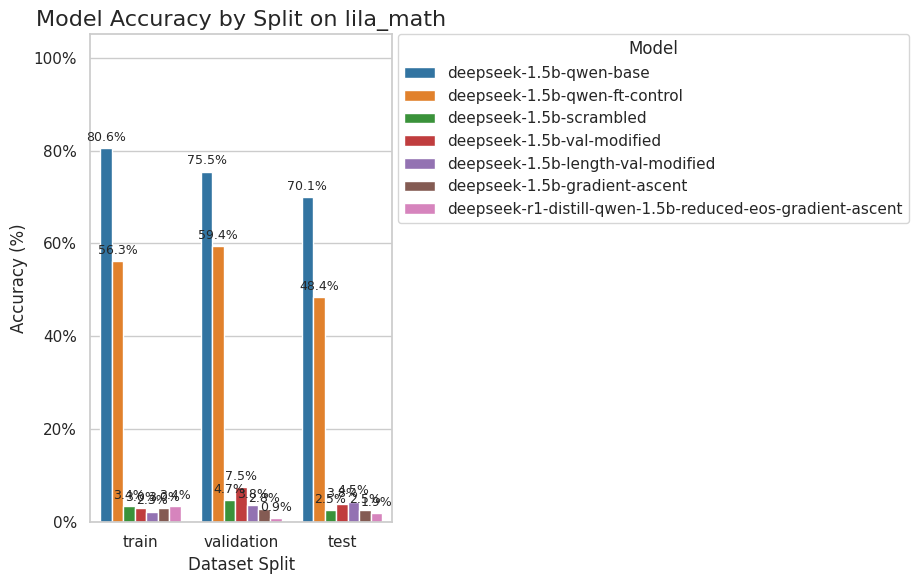

In [69]:
# Cell 12: Load Specific or Latest Results and Visualize

def load_and_visualize(results_filepath: Optional[str] = None):
    """Loads results CSV (specific or latest) for the current benchmark and generates plots."""
    if results_filepath:
        logging.info(f"--- Attempting to Load and Visualize Specific Results File: {results_filepath} ---")
    else:
        logging.info(f"--- Attempting to Load and Visualize Latest Results for Benchmark: {config.benchmark_name} ---")

    # Re-instantiate processor and visualizer to ensure they use the current config
    # Config is already global and set by Cell 4
    try:
        res_processor = ResultsProcessor(config)
        viz = Visualizer(config)
    except Exception as e:
        logging.error(f"Failed to initialize components for loading/visualization: {e}")
        return

    # 1. Load results CSV (specific or latest)
    loaded_results_df, timestamp_str = res_processor.load_results_csv(filepath=results_filepath)

    if loaded_results_df is None or loaded_results_df.empty:
        if results_filepath:
             logging.error(f"Could not load or found empty specified results file: {results_filepath}. Cannot visualize.")
        else:
             logging.error(f"Could not load or found empty latest results file for benchmark '{config.benchmark_name}'. Cannot visualize.")
        return

    # 2. Calculate accuracy based on loaded data and current config
    accuracy_df = viz.calculate_accuracy_df(loaded_results_df)

    # 3. Plot the accuracy using the appropriate function, passing the timestamp
    if not accuracy_df.empty:
        logging.info(f"Generating plot(s) from loaded results (Timestamp: {timestamp_str or 'N/A'})...")
        # Determine plot type based on config (which should match loaded data if correct file was loaded)
        if config.grouping_col == 'split':
            viz.plot_accuracy_by_split(accuracy_df, timestamp_str=timestamp_str)
        elif config.grouping_col == 'subject':
            viz.plot_accuracy_by_subject(accuracy_df, timestamp_str=timestamp_str)
            # Also plot the combined subject accuracy
            viz.plot_combined_subject_accuracy(accuracy_df, timestamp_str=timestamp_str)
            # Also plot all subjects in one graph
            viz.plot_all_subjects_combined(accuracy_df, timestamp_str=timestamp_str)
        else:
            logging.warning(f"No specific plotting function defined for grouping column: {config.grouping_col}")
    else:
        logging.warning("Skipping plot generation as no accuracy data could be prepared from the loaded file (check logs for filtering/grouping details).")

    logging.info("--- Load and Visualize Finished ---")

# --- USER CONFIGURATION ---
# Set to the full path of a specific results CSV file, or None to load the latest.
# Example: specific_results_filepath = "/content/drive/MyDrive/Colab_Notebooks/Multi_MATH_Eval/results/hf_math/hf_math_evaluation_results_20240115_103000.csv"
specific_results_filepath = None
specific_results_filepath = "/content/drive/MyDrive/Colab_Notebooks/Multi_MATH_Eval/results/lila_math/lila_math_evaluation_results_20250504_230401.csv"
# ------------------------

# Run the function to load and visualize
# Make sure Cell 4 has the correct benchmark_name selected!
load_and_visualize(results_filepath=specific_results_filepath)